This notebook analyzes the results of the human annotation experiment.

In [1]:
%load_ext autoreload
%autoreload 2

import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
sys.path.append('..')

import data
from config import *
import util
import viz
import annot_helper
df = data.load_all_labs()

# get fnames
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f] # these start at 00001
fname_ids = np.array([f[:-4] for f in fname_nps])
idxs_calculated = np.array([int(x) - 1 for x in fname_ids]) # this starts at 0

# load the annotations
annotations, mat_list = annot_helper.get_annotations()

# analyze results

In [2]:
# there are n = 360 images, with 3 annotators each

# this is True when the annotator identifies the pair as the same
sames_mat = np.vectorize(annot_helper.same_or_not)(mat_list) # (n, 3)
sames = sames_mat.flatten(order='F') # (n * 3)

# this is 1, 2, 3, nan depending on how well the annotator knows the celeb
knows_mat = np.vectorize(annot_helper.knows_well)(mat_list) # (n, 3)
# could impute the values where knows is not answered
# np.sum(np.isnan(knows)) / knows.size
# knows_mat[np.isnan(knows_mat)] = 3
knows = knows_mat.flatten(order='F') # (n * 3)

print('inter-rater agreement (prob that 2 annotators agreed on a label)')
n_agrees = np.sum((sames_mat[:, 0] == sames_mat[:, 1])) + np.sum(sames_mat[:, 0] == sames_mat[:, 2]) + np.sum(sames_mat[:, 1] == sames_mat[:, 2])
print(n_agrees, f'{n_agrees / sames_mat.size:0.3f}')
# viz.annotators_num_plot(annotations) # plot number of annotators

inter-rater agreement (prob that 2 annotators agreed on a label)
796 0.737


## basic viz - dup vs fake/real

In [53]:
# get labs, a dataframe which gives groundtruth labels for the image (race, gender, fake/real/dup)
fnames = sorted([f for f in os.listdir(oj(DIR_PROJ_ANNOTATIONS, 'ims'))
        if 'png' in f])

# get labels for n of the images
labs = {
    'race=black': list(map(lambda x: 'Black' in x, fnames)),
    'race=white': list(map(lambda x: 'White' in x, fnames)),    
    'female': list(map(lambda x: '0_' in x, fnames)),
    'male': list(map(lambda x: '1_' in x, fnames)),    
    'dup': list(map(lambda x: 'dup' in x, fnames)),
    'fake': list(map(lambda x: 'fake' in x, fnames)),
    'real': list(map(lambda x: 'real' in x, fnames)),
    'celeb_id': [int(f.split('_')[2]) for f in fnames],
    'fnames': fnames
}
labs = pd.DataFrame.from_dict(labs)

# duplicate the labels so that it becomes (n * 3)
labs = labs.append(labs, ignore_index=True).append(labs, ignore_index=True)

# add labels, set up lists to do conditioning on
d = {
    'knows well': knows == 1,
    'knows moderately well': knows == 2,
    'not at all': knows == 3
}
l_well = list(d.keys())
for k in l_well:
    labs[k] = d[k]
l_type = ['dup', 'fake', 'real']
l_gender = ['female', 'male']
l_race = ['race=black', 'race=white']    

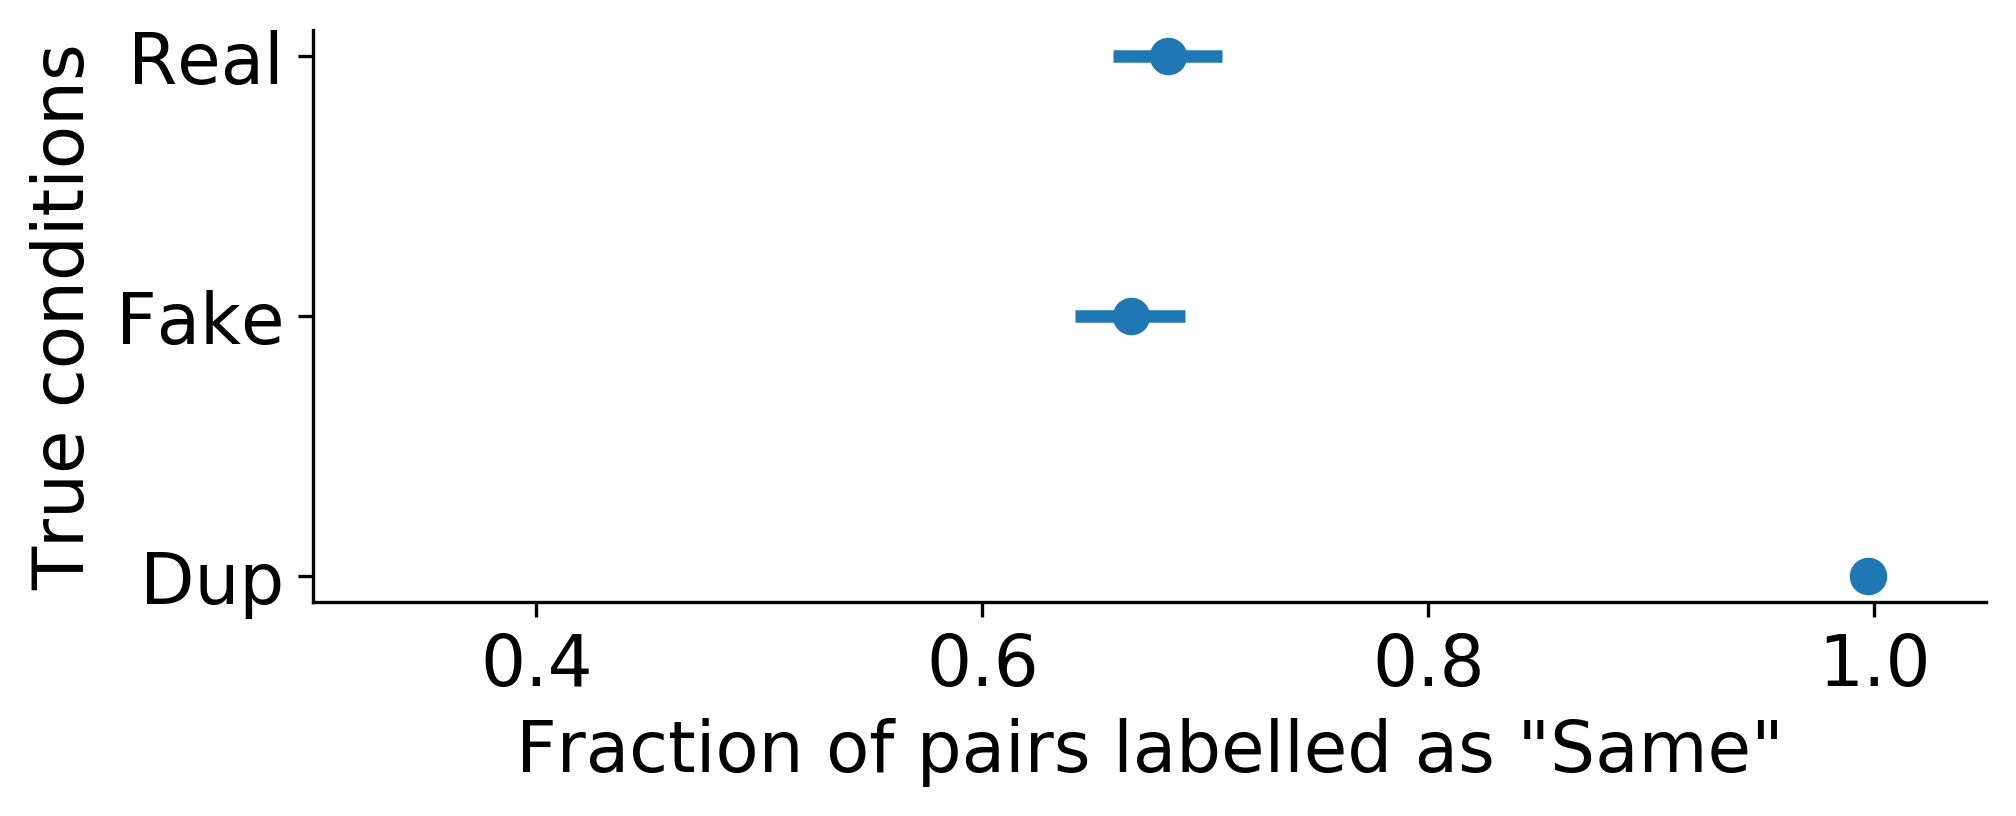

In [54]:
# fake vs real
means_full, sems_full = viz.boxplot_subgroups(sames,
                  labs, l_type,
                  confs='wilson')
util.savefig('ann_main')

\begin{tabular}{lll}
\toprule
{} &           Fake pairs &           Real pairs \\
\midrule
All                   &  66.7 (64.14, 69.10) &  68.3 (65.83, 70.73) \\

\midrule
Knows well            &  86.4 (82.17, 89.78) &  90.5 (86.58, 93.42) \\
Knows moderately well &  68.7 (62.75, 74.01) &  65.8 (60.02, 71.06) \\
Not at all            &  49.0 (41.93, 56.07) &  46.9 (39.94, 54.06) \\
\bottomrule\\
\end{tabular}



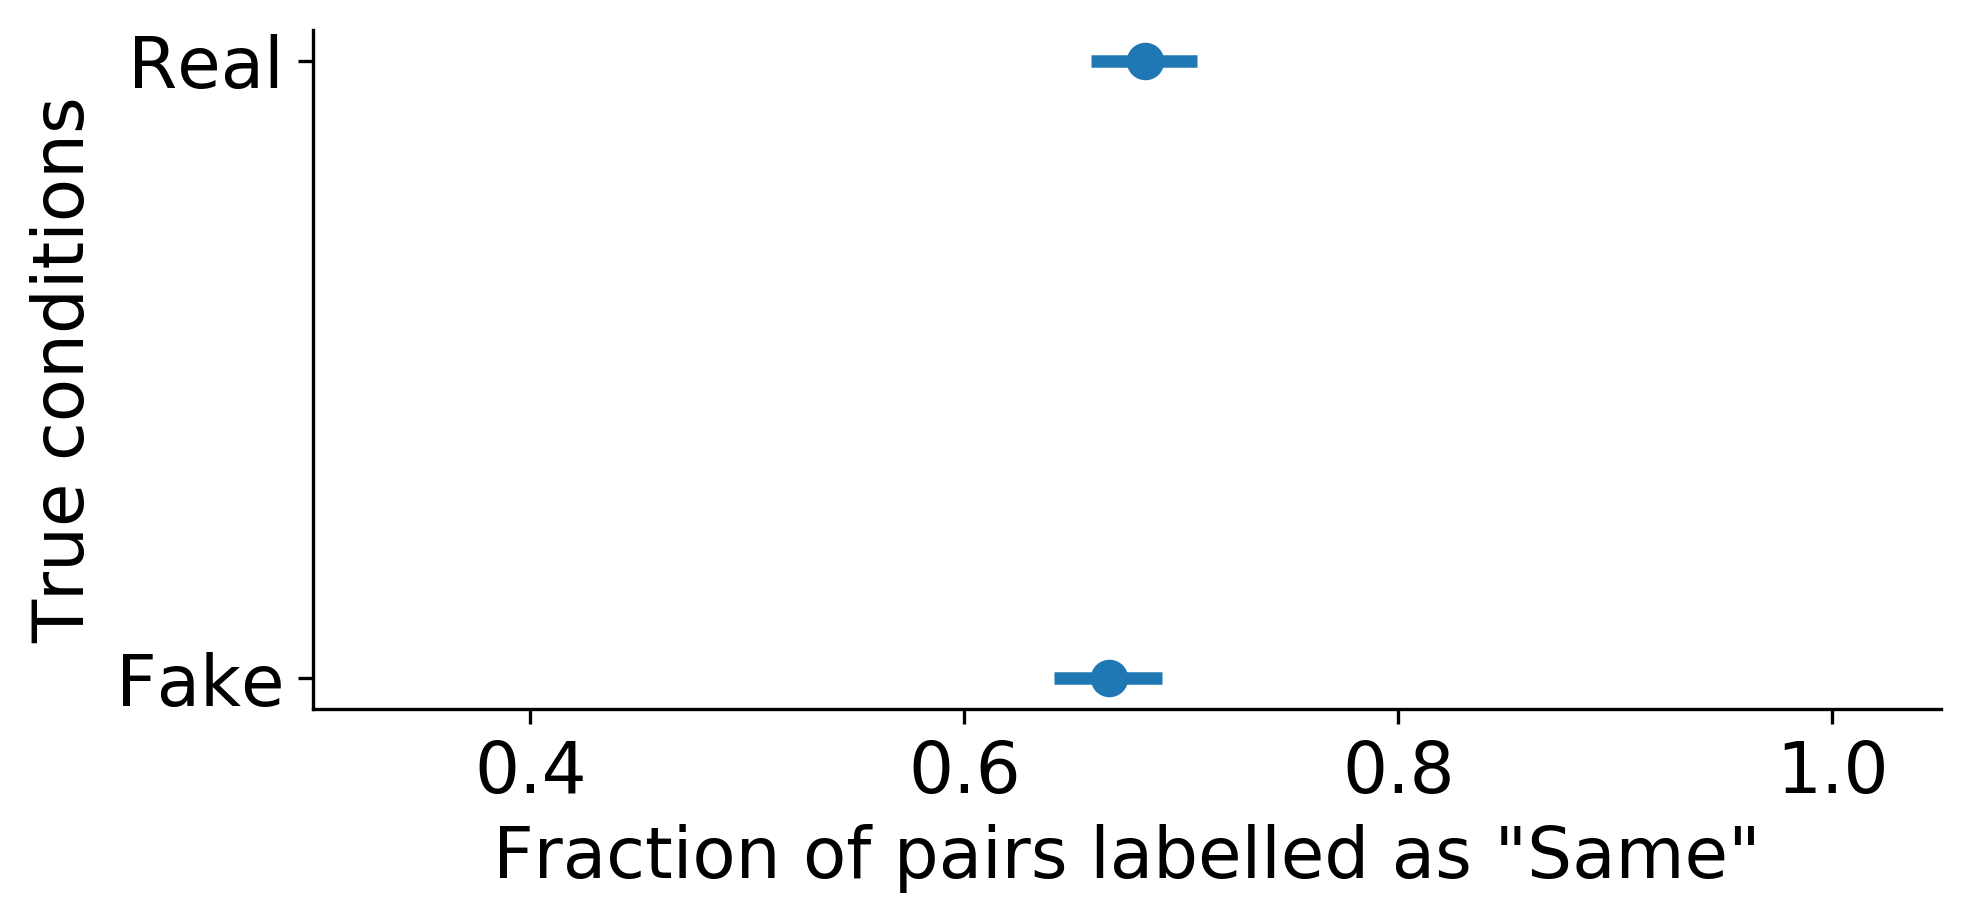

In [92]:
means_full, sems_full = viz.boxplot_subgroups(sames,
                  labs, ['fake', 'real'],
                  confs='wilson')
# viz.print_table(means_full, sems_full, index=['fake', 'real'])
# viz.print_table(means_knows, sems_knows, index=ks)
viz.print_table(np.concatenate((means_full, means_knows)), 
                np.concatenate((sems_full, sems_knows)),
                index=['all', 'real'] + ks)
# viz.print_table(means_knows, sems_knows, index=ks)

In [64]:
l_type

['dup', 'fake', 'real']

## look at subgroups

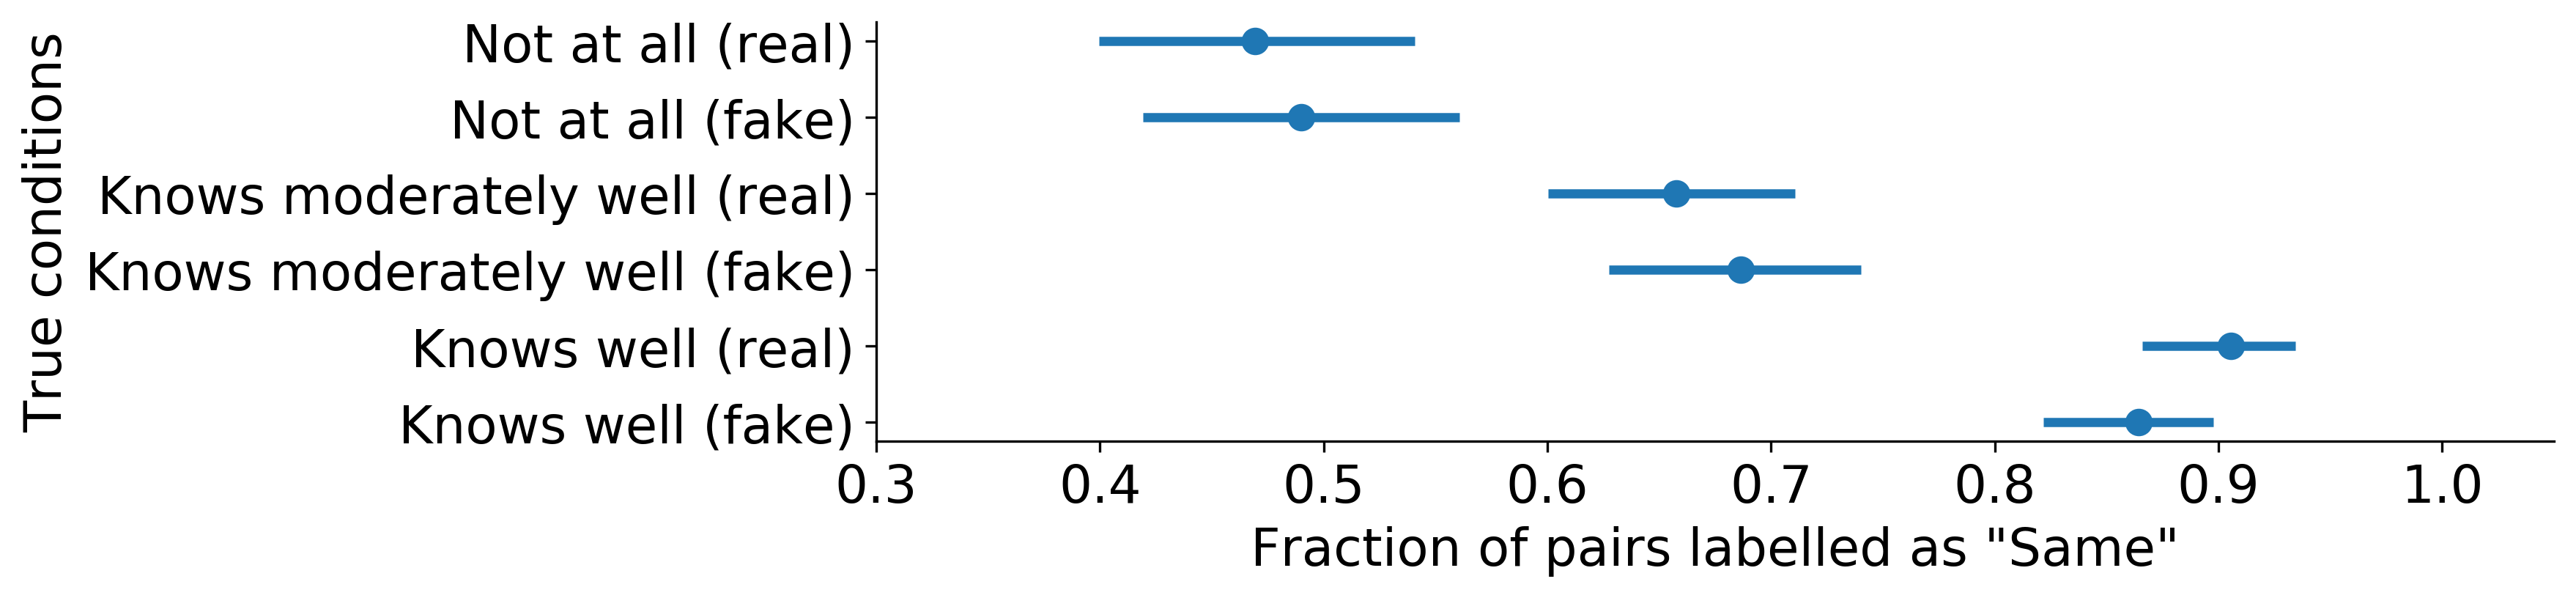

In [45]:
# fake vs real when considering knowledge of celeb
l_non_dup = [k for k in l_type if not 'dup' in k]
labs_intersect, ks = annot_helper.add_intersections(labs, l_well, l_non_dup)
means_knows, sems_knows = viz.boxplot_subgroups(sames, labs_intersect,
                  [k for k in ks if not 'dup' in k],
                  confs='wilson',
                  width=12) #, confs=sames)
util.savefig('ann_knowledge')

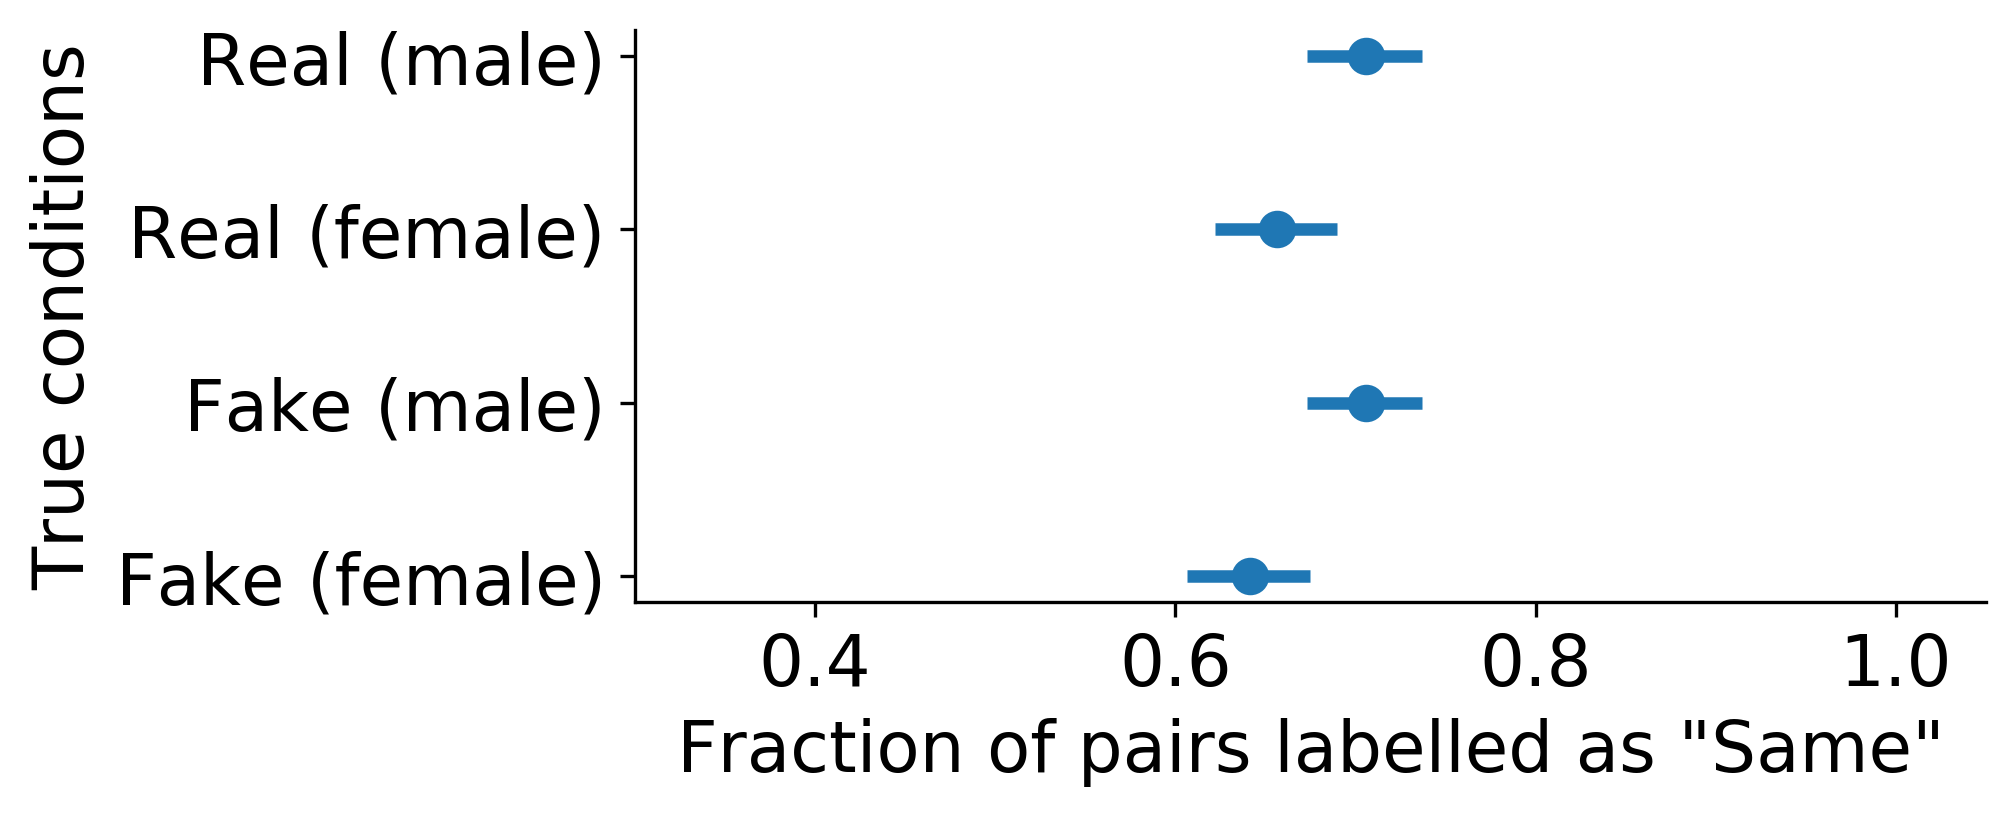

In [6]:
# fake vs real considering gender
labs_intersect, ks_type_gender = annot_helper.add_intersections(labs, l_type, l_gender)
viz.boxplot_subgroups(sames, labs_intersect,
                  [k for k in ks_type_gender if not 'dup' in k],
                  confs='wilson')
util.savefig('ann_gender')

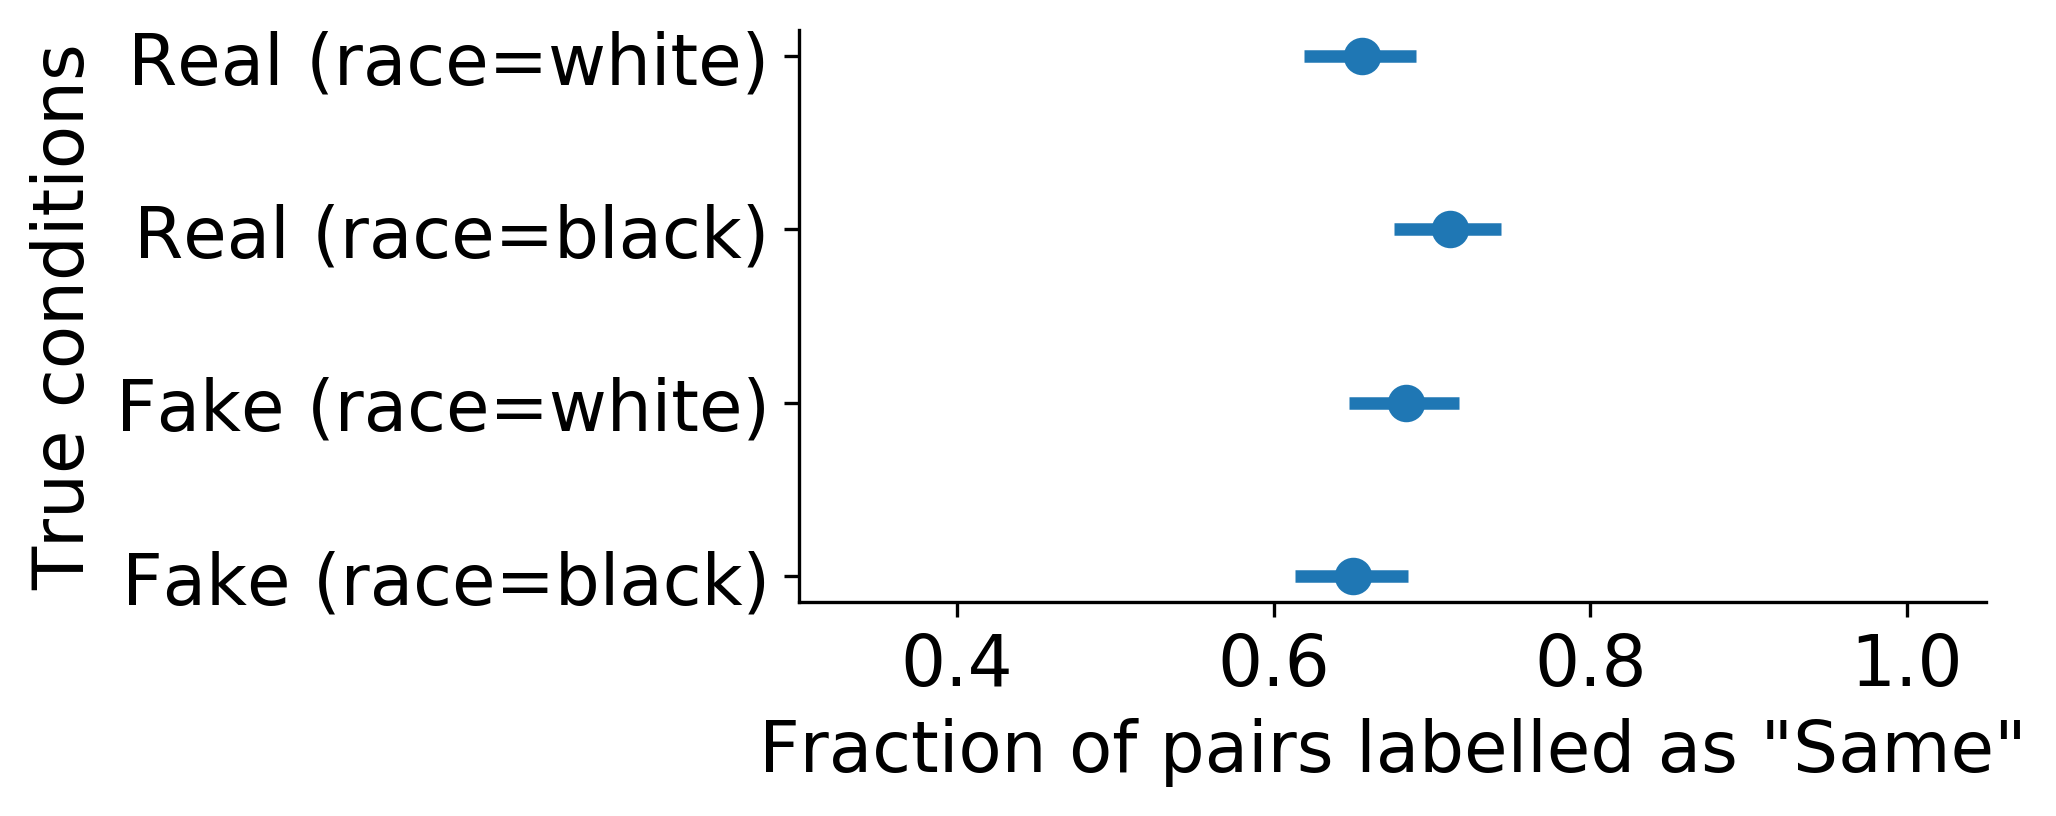

In [7]:
# fake vs real considering gender
labs_intersect, ks_type_race = annot_helper.add_intersections(labs, l_type, l_race)
viz.boxplot_subgroups(sames, labs_intersect,
                  [k for k in ks_type_race if not 'dup' in k],
                  confs='wilson')
util.savefig('ann_race')

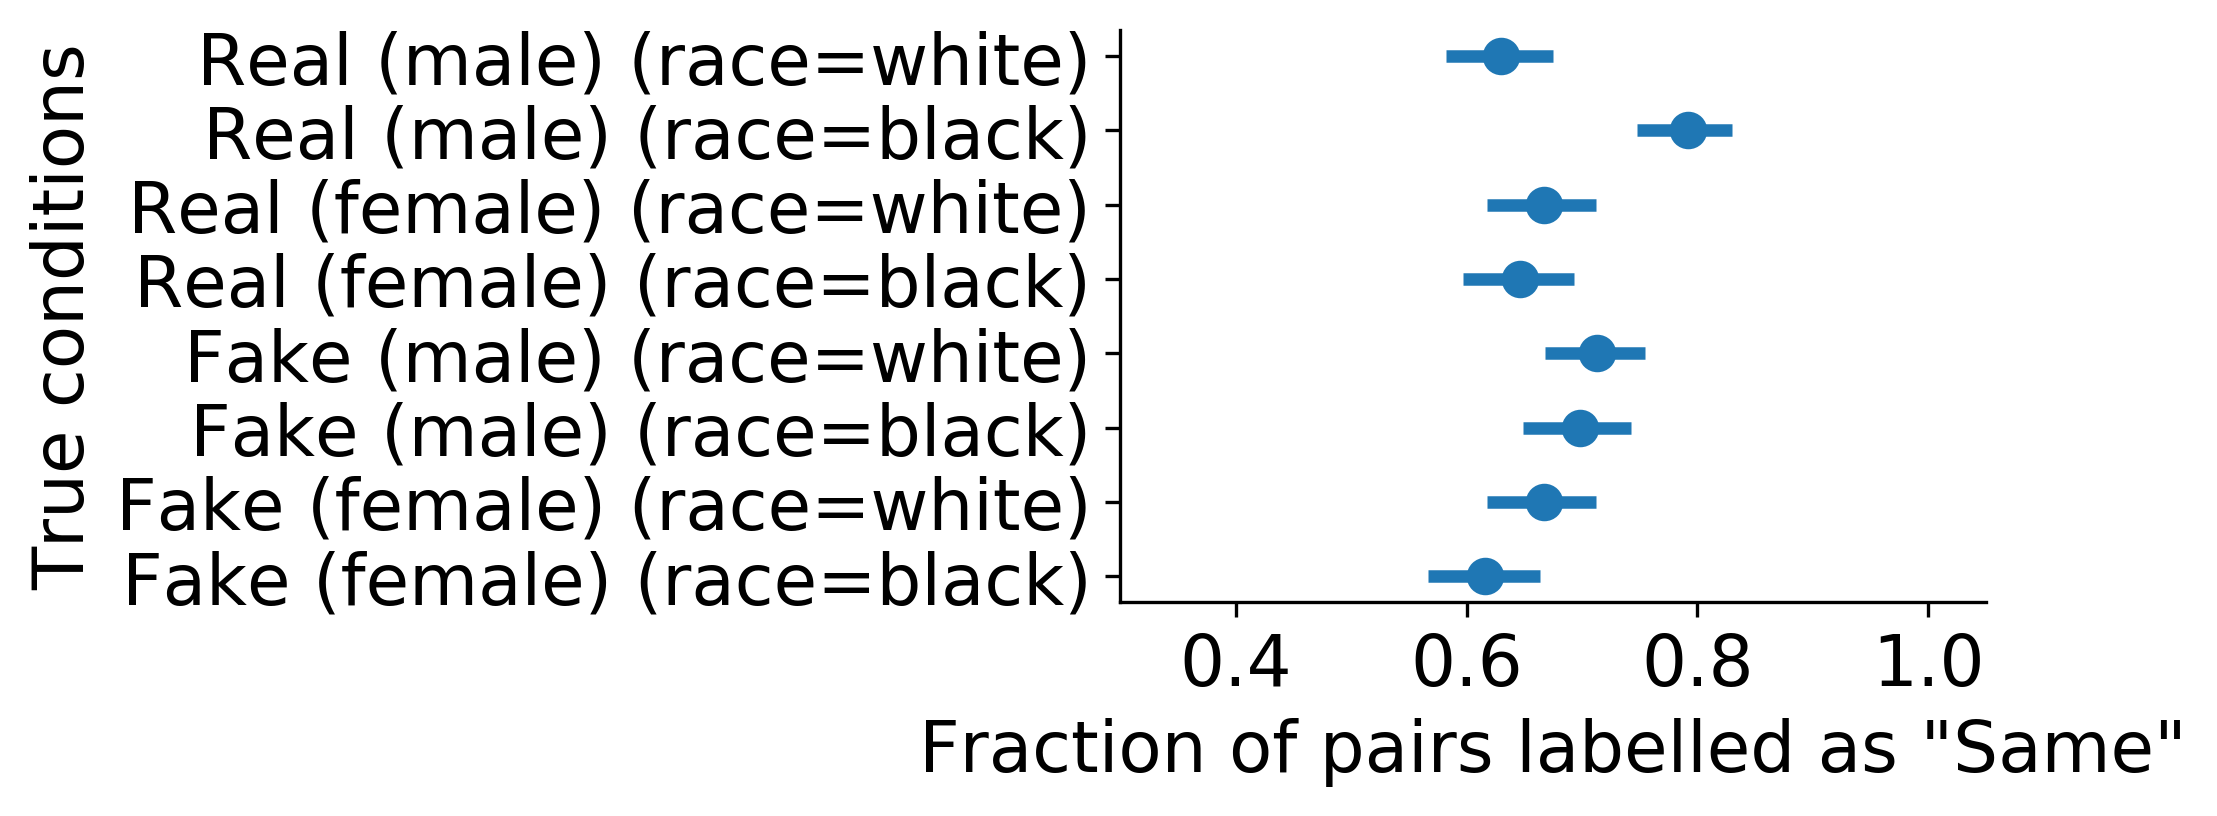

In [8]:
# fake vs real considering gender + race
labs_intersect, ks_intersect = annot_helper.add_intersections(labs, ks_type_gender, l_race)
viz.boxplot_subgroups(sames, labs_intersect,
                  [k for k in ks_intersect if not 'dup' in k],
                  confs='wilson')
util.savefig('ann_intersection')

# compare human errs to facerec-errs

**question: for the celebrities the annotators think are same vs different (on the real pairs), what does the facerec think?**

Note: this section requires the pre-computed face-rec distances

In [129]:
dists_facial = data.get_dists('facenet_vgg2')

In [140]:
# get pairs which are the same + human labels
labs_real = labs[labs['real']] 
sames_real = sames[labs['real']]

# get labs to compare (in truth all should be same)
celeb_ids_sames = labs_real[sames_real].celeb_id
celeb_ids_diffs = labs_real[~sames_real].celeb_id

# get dist for each of these celebs
celeb_dists_by_id = {}
for celeb_id in tqdm(labs_real.celeb_id.unique()):
    fname_ids = df[df.id == celeb_id].index.values
    dist_list = []
    for i in range(len(fname_ids)):
        for j in range(i):
            dist_list.append(dists_facial[fname_ids[i], fname_ids[j]])
    celeb_dists_by_id[celeb_id] = np.mean(dist_list)
    
r = {
    'Same': celeb_ids_sames.map(celeb_dists_by_id),
    'Different': celeb_ids_diffs.map(celeb_dists_by_id)
}

100%|██████████| 120/120 [00:00<00:00, 1082.91it/s]


(array([0.35171071, 0.70342143, 1.75855356, 1.75855356, 2.63783035,
        2.98954106, 3.86881784, 2.8136857 , 1.58269821, 1.58269821]),
 array([0.45727614, 0.50715765, 0.55703915, 0.60692066, 0.65680216,
        0.70668367, 0.75656517, 0.80644668, 0.85632818, 0.90620969,
        0.95609119]),
 <a list of 10 Patch objects>)

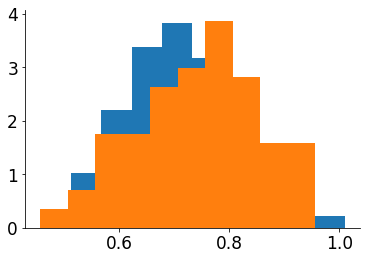

In [147]:
plt.hist(r['Same'], density=True)
plt.hist(r['Different'], density=True)

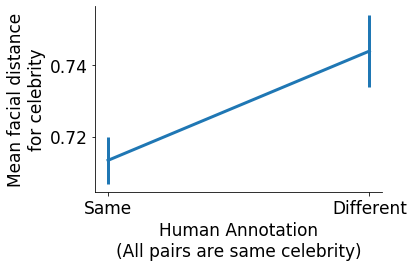

In [164]:
ks = r.keys()
means = [np.nanmean(r[x]) for x in ks]
stds = [np.nanstd(r[x]) / np.sqrt(np.sum(~r[x].isna())) for x in ks]
plt.errorbar(np.arange(2), means, yerr=stds)
plt.xticks(np.arange(2), ks)
plt.xlabel('Human Annotation\n(All pairs are same celebrity)')
plt.ylabel('Mean facial distance\nfor celebrity')
util.savefig('fig_ann_human_vs_facerec')
plt.show()